In [23]:
import sys
sys.path.append('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/')
import yaml
import torch
# from models_.lvmogp_svi import LVMOGP_SVI
from modules.prepare_and_train_model import LVMOGP_SVI 
from models_.gaussian_likelihood import GaussianLikelihood
from modules.prepare_data import *
from util_functions import *

In [24]:
# Specify model and likelihood

with open('/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/configs/train_lvmogp_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

my_model = LVMOGP_SVI(
    n_outputs = config['n_outputs'],
    n_input = config['n_input_train'],
    input_dim = config['input_dim'],
    latent_dim = config['latent_dim'],
    n_inducing_input = config['n_inducing_input'],
    n_inducing_latent = config['n_inducing_latent'],
    data_Y = None,
    pca = config['pca'],
    learn_inducing_locations_latent = config['learn_inducing_locations_latent'],
    learn_inducing_locations_input = config['learn_inducing_locations_input'],
    latent_kernel_type = config['latent_kernel_type'],
    input_kernel_type = config['input_kernel_type']
)

my_likelihood = GaussianLikelihood()

In [25]:
# Load trained model and likelihood

model_state_dict = torch.load(config['model_path'])
my_model.load_state_dict(model_state_dict)

likelihood_state_dict = torch.load(config['likelihood_path'])
my_likelihood.load_state_dict(likelihood_state_dict)

<All keys matched successfully>

In [26]:
if config['dataset_type'] == 'synthetic_regression':
        data_inputs, data_Y_squeezed, ls_of_ls_train_input, ls_of_ls_test_input, train_sample_idx_ls, test_sample_idx_ls = prepare_synthetic_regression_data(config)

# Testing

### first evaluate on all data, including train and test ... 

In [27]:
my_model.eval()
my_likelihood.eval()

all_index_latent = np.array([[i]*config['n_input'] for i in range(config['n_outputs'])]).reshape(-1).tolist() 
all_index_input = [i for i in range(config['n_input'])] * config['n_outputs'] 
len_outputs = len(all_index_latent)
assert len_outputs == len(all_index_input)
all_mean_outputs = my_model.X.q_mu.data

test_mini_batch_size = 1000

all_pred_mean = torch.zeros(len_outputs)
all_pred_var = torch.zeros(len_outputs)
test_continue = True
test_start_idx = 0
test_end_idx = test_mini_batch_size

# iteratively inference
while test_continue:
    batch_latent = all_mean_outputs[all_index_latent[test_start_idx:test_end_idx]]
    batch_input = data_inputs[all_index_input[test_start_idx:test_end_idx]]
    batch_output = my_likelihood(my_model(batch_latent, batch_input))
    all_pred_mean[test_start_idx:test_end_idx] = batch_output.loc.detach()
    all_pred_var[test_start_idx:test_end_idx] = batch_output.variance.detach()

    if test_end_idx < len_outputs:
        test_start_idx += test_mini_batch_size
        test_end_idx += test_mini_batch_size
        test_end_idx = min(test_end_idx, len_outputs)
    else:
        test_continue = False

In [28]:
# finer grid for better visualization ... nothing to do with RMSE computation ... 
n_data4visual = 500
inputs_total4visual = Tensor(np.linspace(config['init_inducing_input_LB'], config['init_inducing_input_UB'], n_data4visual))
all_index_latent4visual = np.array([[i]*n_data4visual for i in range(config['n_outputs'])]).reshape(-1).tolist() 
all_index_input4visual = [i for i in range(n_data4visual)] * config['n_outputs'] 

len_outputs4visual = len(all_index_latent4visual)
assert len_outputs4visual == len(all_index_input4visual)

all_pred_mean4visual = torch.zeros(len_outputs4visual)
all_pred_var4visual = torch.zeros(len_outputs4visual)

test_continue = True
test_start_idx = 0
test_end_idx = test_mini_batch_size

while test_continue:
    batch_latent = all_mean_outputs[all_index_latent4visual[test_start_idx:test_end_idx]]
    batch_input = inputs_total4visual[all_index_input4visual[test_start_idx:test_end_idx]]
    batch_output = my_likelihood(my_model(batch_latent, batch_input))
    all_pred_mean4visual[test_start_idx:test_end_idx] = batch_output.loc.detach()
    all_pred_var4visual[test_start_idx:test_end_idx] = batch_output.variance.detach()

    if test_end_idx < len_outputs4visual:
        test_start_idx += test_mini_batch_size
        test_end_idx += test_mini_batch_size
        test_end_idx = min(test_end_idx, len_outputs4visual)
    else:
        test_continue = False

## Train/Test data RMSE

In [29]:
train_data_predict = all_pred_mean[train_sample_idx_ls]
train_rmse = (train_data_predict - data_Y_squeezed[train_sample_idx_ls]).square().mean().sqrt()
print('Global Train RMSE', train_rmse)

w_test_data_predict = all_pred_mean[test_sample_idx_ls]
test_rmse = (w_test_data_predict - data_Y_squeezed[test_sample_idx_ls]).square().mean().sqrt()
print('Global Test RMSE', test_rmse)

Global Train RMSE tensor(0.3001)
Global Test RMSE tensor(0.4273)


## Train/Test data NLL

In [30]:
train_nll = neg_log_likelihood(Target=data_Y_squeezed[train_sample_idx_ls], GaussianMean=all_pred_mean[train_sample_idx_ls], GaussianVar=all_pred_var[train_sample_idx_ls])
test_nll = neg_log_likelihood(Target=data_Y_squeezed[test_sample_idx_ls], GaussianMean=all_pred_mean[test_sample_idx_ls], GaussianVar=all_pred_var[test_sample_idx_ls])

print('Global Train negative log likelihood:', train_nll)
print('Global Test negative log likelihood:', test_nll)

Global Train negative log likelihood: tensor(0.2141)
Global Test negative log likelihood: tensor(0.5852)


## Visual Inspect

In [31]:
def evaluate_on_simgle_output(w_function_index):
    # Pick the index of the funtion to show
    # w_function_index = 982

    performance_dirct = {}
    w_train_input = data_inputs[ls_of_ls_train_input[w_function_index]]
    w_train_start = 0
    for i in range(w_function_index):
        w_train_start += len(ls_of_ls_train_input[i]) # don't assume every output has the same length of inputs
    w_train_end = w_train_start + len(ls_of_ls_train_input[w_function_index])
    w_train_target = data_Y_squeezed[train_sample_idx_ls][w_train_start:w_train_end]
    w_train_predict = train_data_predict[w_train_start:w_train_end]
    train_rmse_ = (w_train_target - w_train_predict).square().mean().sqrt()
    train_nll_ = neg_log_likelihood(w_train_target, all_pred_mean[train_sample_idx_ls][w_train_start:w_train_end], all_pred_var[train_sample_idx_ls][w_train_start:w_train_end])
    # print('train rmse', train_rmse_)
    # print('train nll:', train_nll_)
    performance_dirct['train_rmse'] = train_rmse_
    performance_dirct['train_nll'] = train_nll_

    w_test_input = data_inputs[ls_of_ls_test_input[w_function_index]]
    w_test_start = 0
    for j in range(w_function_index):
        w_test_start += len(ls_of_ls_test_input[i])
    w_test_end = w_test_start + len(ls_of_ls_test_input[w_function_index])
    w_test_target = data_Y_squeezed[test_sample_idx_ls][w_test_start:w_test_end]
    w_test_predict = w_test_data_predict[w_test_start:w_test_end]
    test_rmse_ = (w_test_predict - w_test_target).square().mean().sqrt()
    test_nll_ = neg_log_likelihood(w_test_target, all_pred_mean[test_sample_idx_ls][w_test_start:w_test_end], all_pred_var[test_sample_idx_ls][w_test_start:w_test_end])
    # print('test rmse', test_rmse_)
    # print('test nll', test_nll_)
    performance_dirct['test_rmse'] = test_rmse_
    performance_dirct['test_nll'] = test_nll_

    w_gp_input = data_inputs
    w_gp_start = w_gp_input.shape[0] * w_function_index
    w_gp_end = w_gp_start + w_gp_input.shape[0]
    w_gp_target = data_Y_squeezed[w_gp_start:w_gp_end]

    # NOTE: comment these since bad visualization ... 
    # w_gp_pred_mean = all_pred_mean[w_gp_start:w_gp_end]
    # w_gp_pred_std = all_pred_var[w_gp_start:w_gp_end]

    w_gp4visual_start = n_data4visual * w_function_index
    w_gp4visual_end = n_data4visual * (w_function_index + 1)
    w_gp_pred_mean = all_pred_mean4visual[w_gp4visual_start:w_gp4visual_end]
    w_gp_pred_std = all_pred_var4visual.sqrt()[w_gp4visual_start:w_gp4visual_end]

    return w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct
    

# Loop over all function index

In [32]:
train_rmse_list = [] # list of tensors
test_rmse_list = []
train_nll_list = []
test_nll_list = []
for output_index in range(config['n_outputs']):
    _, _, _, _, _, _, performance_dirct = evaluate_on_simgle_output(output_index)
    train_rmse_list.append(performance_dirct['train_rmse'])
    test_rmse_list.append(performance_dirct['test_rmse'])
    train_nll_list.append(performance_dirct['train_nll'])
    test_nll_list.append(performance_dirct['test_nll'])

In [33]:
def find_median_index(lst):
    sorted_lst = sorted(lst)
    n = len(lst)
    
    if n % 2 != 0:
        median = sorted_lst[n // 2]
        return lst.index(median)
    else:
        mid1 = sorted_lst[n // 2 - 1]
        mid2 = sorted_lst[n // 2]
        
        return lst.index(mid1)  # lst.index(mid2)

In [34]:
print('The output index with WORSE test rmse performance: ', test_rmse_list.index(max(test_rmse_list)))
print('The output index with WORSE test nll performance: ', test_nll_list.index(max(test_nll_list)))
print('------' * 10)
print('The output index with MIDDLE test rmse performance:', find_median_index(test_rmse_list))
print('The output index with MIDDLE test nll performance:', find_median_index(test_nll_list))
print('------' * 10)
print('The output index with BEST test rmse performance: ', test_rmse_list.index(min(test_rmse_list)))
print('The output index with BEST test nll performance: ', test_nll_list.index(min(test_nll_list)))

The output index with WORSE test rmse performance:  12
The output index with WORSE test nll performance:  12
------------------------------------------------------------
The output index with MIDDLE test rmse performance: 4
The output index with MIDDLE test nll performance: 64
------------------------------------------------------------
The output index with BEST test rmse performance:  14
The output index with BEST test nll performance:  14


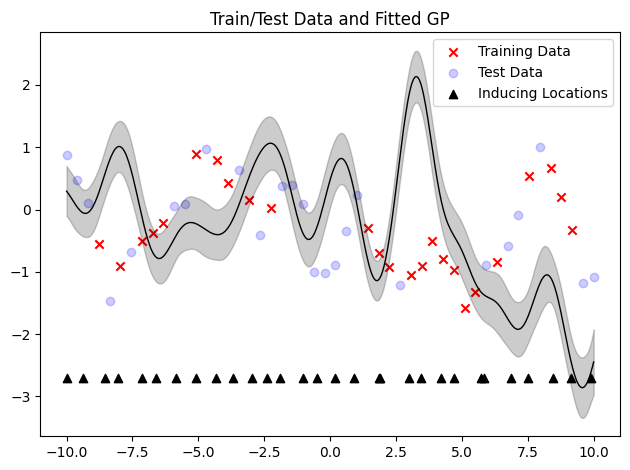

In [42]:
function_index = 12
w_train_input, w_train_target, w_test_input, w_test_target, w_gp_pred_mean, w_gp_pred_std, performance_dirct = evaluate_on_simgle_output(function_index)
picture_save_path = f'/Users/jiangxiaoyu/Desktop/All Projects/GPLVM_project_code/experi_results/func_id_{function_index}_numofoutput_{config["n_outputs"]}.png'
plot_traindata_testdata_fittedgp(train_X=w_train_input, train_Y=w_train_target, test_X=w_test_input, test_Y=w_test_target, gp_X=inputs_total4visual, gp_pred_mean=w_gp_pred_mean, gp_pred_std=w_gp_pred_std, inducing_points_X=my_model.variational_strategy.inducing_points_input.data, n_inducing_C=config['n_inducing_input'], picture_save_path=picture_save_path) # NOTE: input is C not X

In [36]:
print(my_model.covar_module_latent.outputscale.detach())
print(my_model.covar_module_latent.base_kernel.lengthscale.detach())
print(my_model.covar_module_input.outputscale.detach())
print(my_model.covar_module_input.base_kernel.lengthscale.detach())
print(my_likelihood.noise.detach())

tensor(0.8472)
tensor([[0.5653, 0.7868]])
tensor(0.8470)
tensor([[0.6965]])
tensor([0.0002])
